# Alzheimer's Classification [Train]

## Config

In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

from PIL import Image
from numpy import asarray
import gc
import matplotlib.pyplot as plt
import math
import multiprocessing
import numpy as np
import pandas as pd
import random
import time
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import StandardScaler
import torchmetrics
import cv2
import pickle
import transformers
import scipy.io.wavfile as wavfile
import datasets as ds
import librosa
import evaluate
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
from torchaudio.transforms import SpeedPerturbation
from librosa import effects


from glob import glob
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from typing import Dict, List

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using', torch.cuda.device_count(), 'GPU(s)')

Using 1 GPU(s)


In [26]:
class config:
    DEVICE = 'cuda'
    AMP = True
    MAX_GRAD_NORM = 1e7
    NUM_WORKERS = 0 # multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SEED = 20
    VISUALIZE = True

    MODEL = "MIT/ast-finetuned-audioset-10-10-0.4593"
    BATCH_SIZE_TRAIN = 4
    BATCH_SIZE_VALID = 4
    EPOCHS = 10
    FOLDS = 5
    VAL_SIZE = .2   # If FOLDS=1 
    WEIGHT_DECAY = 0.2
    MAX_LR = 1e-5
    DROPOUT = 0.85
    
    
class paths:
    OUTPUT_DIR = './output/'
    DATASET = '../datasets/addresso/train/'
    TRANSCRIPT = '../datasets/addresso/train/transcription/'
    AUDIO = '../datasets/addresso/train/concatenated/'

### Utility functions

In [27]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s: float):
    "Convert to minutes."
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since: float, percent: float):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_logger(filename=paths.OUTPUT_DIR):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger
    
    
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 

    
def sep():
    print("-"*100)
    
LOGGER = get_logger()
seed_everything(config.SEED)

## Loading Data

In [28]:
df = pd.read_csv(paths.DATASET + 'meta_data.csv')
df = df.drop(columns=['age', 'gender', 'mmse'])
df['audio'] = df['ID'].apply(lambda x: paths.AUDIO +str(x)+'.wav')


In [29]:
if config.FOLDS > 1:
    gkf = GroupKFold(n_splits=config.FOLDS)
    for fold, (train_index, valid_index) in enumerate(gkf.split(df, df['class'], df['ID'])):
        df.loc[valid_index, "fold"] = int(fold)

df.head()
print(df.groupby(['fold', 'class']).count())

            ID  audio
fold class           
0.0  0      10     10
     1      12     12
1.0  0      11     11
     1      11     11
2.0  0      12     12
     1      10     10
3.0  0      11     11
     1      10     10
4.0  0      10     10
     1      11     11


In [30]:
class AudioDataset(Dataset):
    def __init__(self, df, mode='train', target_sr=16000):
        self.df = df
        self.mode = mode
        self.f_ex = transformers.AutoFeatureExtractor.from_pretrained(config.MODEL)
        self.target_sr = target_sr

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['audio']
        audio, sr = librosa.load(audio_path)

        if self.mode == 'train' and False:
          audio = self.speech_augmentation(audio, sr)
        
        features = self.preprocess(audio)
        labels = self.df.iloc[idx]['class']
  
        return features, labels

    def preprocess(self, audio):
        inputs = self.f_ex(audio, sampling_rate=self.target_sr, return_tensors="pt")
        return inputs["input_values"].squeeze(0)

    def speech_augmentation(self, audio, sr):
      # Define probabilities for each augmentation
      noise_prob = 0.3  # 30% chance of adding noise
      pitch_prob = 0.4  # 40% chance of pitch shifting
      volume_prob = 0.5  # 50% chance of volume perturbation
      crop_prob = 0.2  # 20% chance of partial cropping

      if random.random() < pitch_prob:
        audio = self.pitch_shift(audio, sr)
      if random.random() < volume_prob:
        audio = self.volume_perturb(audio)

      noise = np.random.normal(0, 0.01, size=audio.shape)  # Mean = 0, Std = 0.01
      audio += noise

      return audio

    def pitch_shift(self, audio, sr, semitones=random.uniform(-2, 2)):
      return effects.pitch_shift(audio, sr=sr, n_steps=semitones)

    def volume_perturb(self, audio, gain_dB=random.uniform(-3, 3)):
      return effects.preemphasis(audio, coef=gain_dB)


In [31]:
class AlzheimersModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = transformers.ASTForAudioClassification.from_pretrained(config.MODEL)
        
        self.model_headless = list(self.model.children())[:-1]

        self.backbone = nn.Sequential(*self.model_headless)
        self.fc = nn.Linear(768, 64)
        self.dropout = nn.Dropout(config.DROPOUT)
        self.fc3 = nn.Linear(64,2)

    def forward(self, x):
        out = self.backbone(x)
        out = self.fc(out.pooler_output)
        out = self.dropout(out)
        out = self.fc3(out)
        return out

In [32]:
print(AlzheimersModel())

AlzheimersModel(
  (model): ASTForAudioClassification(
    (audio_spectrogram_transformer): ASTModel(
      (embeddings): ASTEmbeddings(
        (patch_embeddings): ASTPatchEmbeddings(
          (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ASTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ASTLayer(
            (attention): ASTAttention(
              (attention): ASTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ASTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )


In [33]:
def train_epoch(train_loader, model, optimizer, epoch, scheduler):
    model.train()
    losses = AverageMeter()
    loss_fn = nn.CrossEntropyLoss()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for idx, (features, labels) in enumerate(tepoch):
            features = np.array(features)
            features = torch.from_numpy(features).to(device)
            labels = labels.to(device)
            batch_size = features.size(0)

            optimizer.zero_grad()
            
            outputs = model(features)
            loss = loss_fn(outputs, labels)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            scheduler.step()
            losses.update(loss.item(), batch_size)

    print(f'Train loss: {losses.avg:.4f}')
    return losses.avg


def evaluate(model, valid_loader):
    model.eval()
    losses = AverageMeter()
    acc = AverageMeter()
    auc = torchmetrics.AUROC(task="binary")  # Create the AUC metric
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        all_probs = torch.tensor([]).to(device)
        all_labels = torch.tensor([]).to(device)
        for idx, (features, labels) in enumerate(valid_loader):
            features = np.array(features)
            features = torch.from_numpy(features).to(device)            
            labels = labels.to(device)
            batch_size = features.size(0)

            outputs = model(features)
            pred = torch.argmax(outputs, 1)
            loss = loss_fn(outputs, labels)
            losses.update(loss.item(), batch_size)

            # Get probabilities for the positive class (Alzheimer's)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_probs = torch.cat((all_probs, probs), dim=0)
            all_labels = torch.cat((all_labels, labels), dim=0)

            auc.update(probs, labels) 

            accuracy = torchmetrics.functional.accuracy(pred, labels, 'binary')
            acc.update(accuracy.item(), batch_size)

    roc_auc = auc.compute()
    print(f'Valid loss: {losses.avg:.4f} | Valid accuracy: {acc.avg:.4f} | AUC-ROC: {roc_auc:.4f}')
    return losses.avg, acc.avg, roc_auc, all_probs.cpu().numpy(), all_labels.cpu().numpy()

In [34]:
torch.cuda.empty_cache()
gc.collect()

all_probs = []
all_labels = []

for fold in range(config.FOLDS):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]

    train_dataset = AudioDataset(train_df, mode='train')
    valid_dataset = AudioDataset(valid_df, mode='test')

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE_TRAIN, shuffle=True, num_workers=config.NUM_WORKERS)
    valid_loader = DataLoader(valid_dataset, batch_size=config.BATCH_SIZE_VALID, shuffle=False, num_workers=config.NUM_WORKERS)

    model = AlzheimersModel().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.MAX_LR, weight_decay=config.WEIGHT_DECAY)
    scheduler = OneCycleLR(optimizer, 
                           max_lr=config.MAX_LR, 
                           epochs=config.EPOCHS, 
                           steps_per_epoch=len(train_loader), 
                           pct_start=0.1,
                           anneal_strategy='cos',
                           div_factor=10,
                           final_div_factor=100
                           )

    train_losses = []
    valid_losses = []
    accs = []
    aucs = []

    for epoch in range(config.EPOCHS):
        print(f'Epoch {epoch}')
        train_loss = train_epoch(train_loader, model, optimizer, epoch, scheduler)

        valid_loss, acc, auc, pr, al = evaluate(model, valid_loader)

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        accs.append(acc)
        aucs.append(auc.cpu().numpy())


    all_probs.append(pr)
    all_labels.append(al)
    torch.save(model.state_dict(), f'{paths.OUTPUT_DIR}model_{fold}.pth')
    del model, optimizer, scheduler
    gc.collect()
    torch.cuda.empty_cache()
    


Epoch 0


100%|██████████| 22/22 [00:08<00:00,  2.45batch/s]


Train loss: 0.8081
Valid loss: 0.7587 | Valid accuracy: 0.4091 | AUC-ROC: 0.3417
Epoch 1


100%|██████████| 22/22 [00:08<00:00,  2.45batch/s]


Train loss: 0.8134
Valid loss: 0.7116 | Valid accuracy: 0.6364 | AUC-ROC: 0.5083
Epoch 2


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.8707
Valid loss: 0.6833 | Valid accuracy: 0.5909 | AUC-ROC: 0.5333
Epoch 3


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.7338
Valid loss: 0.7042 | Valid accuracy: 0.4545 | AUC-ROC: 0.4417
Epoch 4


100%|██████████| 22/22 [00:09<00:00,  2.42batch/s]


Train loss: 0.6740
Valid loss: 0.7352 | Valid accuracy: 0.3636 | AUC-ROC: 0.4333
Epoch 5


100%|██████████| 22/22 [00:09<00:00,  2.43batch/s]


Train loss: 0.6441
Valid loss: 0.7291 | Valid accuracy: 0.3636 | AUC-ROC: 0.4167
Epoch 6


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 0.5753
Valid loss: 0.7106 | Valid accuracy: 0.5455 | AUC-ROC: 0.4250
Epoch 7


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.5096
Valid loss: 0.7121 | Valid accuracy: 0.5000 | AUC-ROC: 0.4583
Epoch 8


100%|██████████| 22/22 [00:09<00:00,  2.38batch/s]


Train loss: 0.4970
Valid loss: 0.7174 | Valid accuracy: 0.5000 | AUC-ROC: 0.4500
Epoch 9


100%|██████████| 22/22 [00:09<00:00,  2.36batch/s]


Train loss: 0.4494
Valid loss: 0.7172 | Valid accuracy: 0.5000 | AUC-ROC: 0.4417
Epoch 0


100%|██████████| 22/22 [00:09<00:00,  2.42batch/s]


Train loss: 0.8975
Valid loss: 0.7424 | Valid accuracy: 0.5000 | AUC-ROC: 0.5041
Epoch 1


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.8575
Valid loss: 0.7186 | Valid accuracy: 0.5000 | AUC-ROC: 0.5289
Epoch 2


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.7492
Valid loss: 0.7135 | Valid accuracy: 0.5455 | AUC-ROC: 0.5207
Epoch 3


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.7042
Valid loss: 0.7423 | Valid accuracy: 0.5455 | AUC-ROC: 0.4711
Epoch 4


100%|██████████| 22/22 [00:09<00:00,  2.39batch/s]


Train loss: 0.4841
Valid loss: 0.7634 | Valid accuracy: 0.4545 | AUC-ROC: 0.5124
Epoch 5


100%|██████████| 22/22 [00:09<00:00,  2.41batch/s]


Train loss: 0.6271


KeyboardInterrupt: 

In [ ]:
def flatten(xss):
    return [x for xs in xss for x in xs]

# Save probabilities and labels for each fold in csv
all_probs_n = np.array(flatten(all_probs))
all_labels_n = np.array(flatten(all_labels))
res_df = pd.DataFrame({'probs': all_probs_n, 'labels': all_labels_n})
res_df.to_csv(f'{paths.OUTPUT_DIR}probs_labels.csv', index=False)

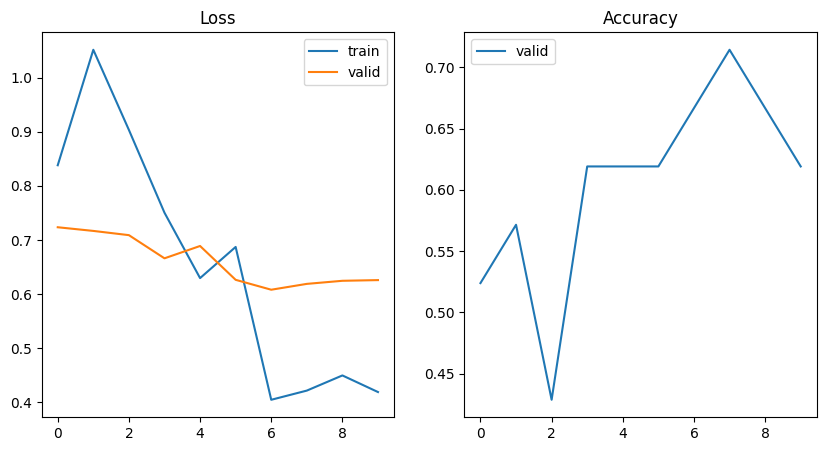

[array([0.3989976 , 0.35648546, 0.40462762, 0.1605817 , 0.56424844,
       0.60294425, 0.5481251 , 0.6594855 , 0.564789  , 0.46678847,
       0.5181045 , 0.54064274, 0.4662027 , 0.47336343, 0.5372056 ,
       0.60732794, 0.5581887 , 0.37423465, 0.41170305, 0.37040988,
       0.5464387 , 0.3348178 ], dtype=float32), array([0.8672924 , 0.72649246, 0.13405125, 0.86881405, 0.12297443,
       0.30091998, 0.70489705, 0.4681549 , 0.5394483 , 0.44207162,
       0.31872544, 0.6177731 , 0.53775144, 0.24396612, 0.38318527,
       0.42833665, 0.19953881, 0.81860113, 0.4507703 , 0.6972632 ,
       0.20544225, 0.8991017 ], dtype=float32), array([0.5524152 , 0.3682385 , 0.41593662, 0.31580052, 0.79324126,
       0.62719285, 0.21081874, 0.5503489 , 0.24458565, 0.23635958,
       0.7563423 , 0.35728613, 0.5814642 , 0.3361215 , 0.35101727,
       0.4466398 , 0.7485349 , 0.46162212, 0.55848354, 0.24409512,
       0.5680794 , 0.40497383], dtype=float32), array([0.48937625, 0.3529128 , 0.45352876, 0.253824

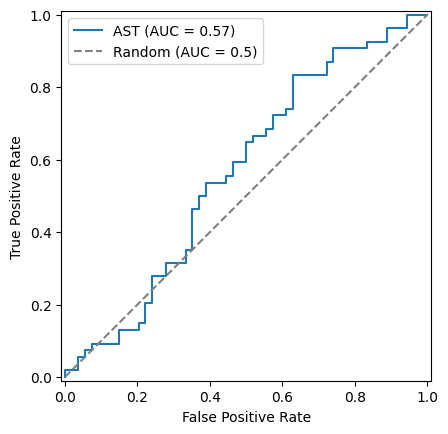

In [ ]:
# Plot training and validation loss and acc
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.title('Loss')
plt.subplot(1, 2, 2)
plt.plot(accs, label='valid')
plt.legend()
plt.title('Accuracy')
plt.show()

def flatten(xss):
    return [x for xs in xss for x in xs]

print(all_probs, all_labels)

fpr, tpr, thresholds = roc_curve(flatten(all_labels), flatten(all_probs))
auc_roc = roc_auc_score(flatten(all_labels), flatten(all_probs))

# fpr, tpr, thresholds = roc_curve(all_labels[0], all_probs[0])
# auc_roc = roc_auc_score(all_labels[0], all_probs[0])

display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_roc, estimator_name='AST')
display.plot()

# Add AUC = 0.5 line
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.5)')

# Show the plot with legend
plt.legend()
plt.show()

# Save the plot
# plt.savefig(f'{paths.OUTPUT_DIR}roc_curve.png')
